<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Sequence Labelling 
  </div> 
  
<div style="
      font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      NER - CHIA Dataset - ALBERT
  </div> 


  <div style=" float:left; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  Jean-baptiste AUJOGUE - Hybrid Intelligence
  </div> 
  
  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  December 2022
  </div>

<a id="TOC"></a>

#### Table Of Content

1. [Dataset](#data) <br>
2. [ALBERT pretrained model](#albert) <br>
3. [Finetuning](#finetune) <br>
4. [Inference](#inference) <br>



#### Reference

- Notebook based on Huggingface Transformers tutorial [notebook](https://github.com/huggingface/notebooks/blob/main/examples/token_classification.ipynb) for sequence labeling (see the full list at [this repo](https://github.com/huggingface/transformers/tree/main/notebooks))
- [Blog](https://github.com/christianversloot/machine-learning-articles/blob/main/albert-explained-a-lite-bert.md) on Albert vs Bert

In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
import os
import sys
import re
import random
import copy
import string

# data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import (
    Dataset, 
    DatasetDict,
    ClassLabel, 
    Features, 
    Sequence, 
    Value,
    load_metric, 
)
from transformers import DataCollatorForTokenClassification

# DL
import torch
import transformers
from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification, 
    TrainingArguments, 
    Trainer,
    pipeline,
)

# viz
from IPython.display import HTML

In [5]:
transformers.__version__

'4.22.2'

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Custom paths & imports

In [7]:
path_to_repo = os.path.dirname(os.getcwd())
path_to_data = os.path.join(path_to_repo, 'datasets', 'chia')
path_to_save = os.path.join(path_to_repo, 'saves', 'NER')
path_to_src  = os.path.join(path_to_repo, 'src')

In [8]:
sys.path.insert(0, path_to_src)

In [120]:
from nlptools.ner.tokenize import tokenize_and_align_labels
from nlptools.ner.metrics import compute_metrics
from nlptools.ner.postprocessing import parse_trf_ner_output, remove_entity_overlaps, correct_entity_boundaries
from nlptools.ner.visualization import render_ner_as_html

#### Constants

In [105]:
def fix_seed(seed = 12345):
    torch.manual_seed(seed)                   # cpu
    torch.cuda.manual_seed(seed)              # gpu
    np.random.seed(seed)                      # numpy
    random.seed(seed)                         # random
    torch.backends.cudnn.deterministic = True # cudnn
    return


fix_seed(seed = 35)

In [10]:
dataset_name = 'chia'
model_name = "albert-base-v2"

<a id="data"></a>

# 1. Dataset

[Table of content](#TOC)

We generate a collection of instances of the `datasets.Dataset` class. These are different from the `torch.utils.data.Dataset` class. 

## 1.1 Load BIO corpus

[Table of content](#TOC)

In [66]:
df_bio = pd.read_csv(os.path.join(path_to_data, 'chia_bio.tsv'), sep = "\t")

df_bio.head(10)

,Id,Sequence_id,Mention,Category
0,NCT00050349_exc,NCT00050349_exc_0,Patients,O
1,NCT00050349_exc,NCT00050349_exc_0,with,O
2,NCT00050349_exc,NCT00050349_exc_0,symptomatic,B-Qualifier
3,NCT00050349_exc,NCT00050349_exc_0,,O
4,NCT00050349_exc,NCT00050349_exc_0,CNS,B-Condition
5,NCT00050349_exc,NCT00050349_exc_0,metastases,I-Condition
6,NCT00050349_exc,NCT00050349_exc_0,,O
7,NCT00050349_exc,NCT00050349_exc_0,or,O
8,NCT00050349_exc,NCT00050349_exc_0,leptomeningeal,B-Condition
9,NCT00050349_exc,NCT00050349_exc_0,involvement,I-Condition


In [67]:
label_list = sorted(list(set(df_bio.Category.unique())))
label_list

['B-Condition',
 'B-Device',
 'B-Drug',
 'B-Measurement',
 'B-Negation',
 'B-Observation',
 'B-Person',
 'B-Procedure',
 'B-Qualifier',
 'B-Temporal',
 'B-Value',
 'B-Visit',
 'I-Condition',
 'I-Device',
 'I-Drug',
 'I-Measurement',
 'I-Negation',
 'I-Observation',
 'I-Person',
 'I-Procedure',
 'I-Qualifier',
 'I-Temporal',
 'I-Value',
 'I-Visit',
 'O']

In [68]:
class_labels = ClassLabel(names = label_list)
label2id = class_labels._str2int
id2label = {v: k for k, v in label2id.items()}

In [69]:
# create B-tag to I-tag mapping at the level of indices
B_I_mapping = {i: label2id['I' + l[1:]] for i, l in id2label.items() if l.startswith('B-')}
B_I_mapping

{0: 12,
 1: 13,
 2: 14,
 3: 15,
 4: 16,
 5: 17,
 6: 18,
 7: 19,
 8: 20,
 9: 21,
 10: 22,
 11: 23}

In [70]:
df_bio['Cat_index'] = df_bio.Category.apply(lambda c: class_labels.str2int(c))

## 1.2 Generate train / valid / test dataset

[Table of content](#TOC)

In [90]:
def get_item_list(df, grp_col, item_col):
    return df.groupby(grp_col).apply(lambda g: g[item_col].tolist()).tolist()


def get_dataset(df_bio):
    data = {
        'ids'     : df_bio.Sequence_id.unique().tolist(),
        'tokens'  : get_item_list(df_bio, 'Sequence_id', 'Mention'),
        'labels'  : get_item_list(df_bio, 'Sequence_id', 'Category'),
        'ner_tags': get_item_list(df_bio, 'Sequence_id', 'Cat_index'),
    }
    return data

In [83]:
# dataset separation: 800 trials for training, 100 trials for validation and 100 trials for testing
ids_bio = sorted(list(set(df_bio.Id.apply(lambda i: i.split('_')[0])))) #[n.split('_')[0] for n in df_bio.Id])))
ids_trn, ids_dev = train_test_split(ids_bio, train_size = 0.8, random_state = 13, shuffle = True)
ids_dev, ids_tst = train_test_split(ids_dev, train_size = 0.5, random_state = 13, shuffle = True)

len(ids_bio), len(ids_trn), len(ids_dev), len(ids_tst)

(1000, 800, 100, 100)

In [84]:
df_trn = df_bio[df_bio.Id.apply(lambda i: i.split('_')[0]).isin(ids_trn)]
df_dev = df_bio[df_bio.Id.apply(lambda i: i.split('_')[0]).isin(ids_dev)]
df_tst = df_bio[df_bio.Id.apply(lambda i: i.split('_')[0]).isin(ids_tst)]

In [91]:
dict_bio = get_dataset(df_bio)
dict_trn = get_dataset(df_trn)
dict_dev = get_dataset(df_dev)
dict_tst = get_dataset(df_tst)

In [92]:
features = Features({
    'ids': Value(dtype = 'string'), 
    'tokens': Sequence(Value(dtype = 'string')), 
    'labels': Sequence(Value(dtype = 'string')),
    'ner_tags': Sequence(class_labels),
})

In [93]:
datasets = DatasetDict({
    'train': Dataset.from_dict(dict_trn, features = features),
    'validation': Dataset.from_dict(dict_dev, features = features),
    'test': Dataset.from_dict(dict_tst, features = features),
    'all' : Dataset.from_dict(dict_bio, features = features),
})

<a id="albert"></a>

# 2. ALBERT pretrained model

[Table of content](#TOC)

## 2.1 ALBERT tokenizer

[Table of content](#TOC)


In [95]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 684/684 [00:00<00:00, 684kB/s]
C:\Users\jbaujogue\Anaconda3\envs\transformers_nlp\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jbaujogue\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)

In [96]:
tokenized_datasets = datasets.map(
    function = lambda examples: tokenize_and_align_labels(tokenizer, examples, B_I_mapping), 
    batched  = True,
)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.42ba/s]


In [97]:
data_collator = DataCollatorForTokenClassification(tokenizer)

<AxesSubplot: ylabel='Frequency'>

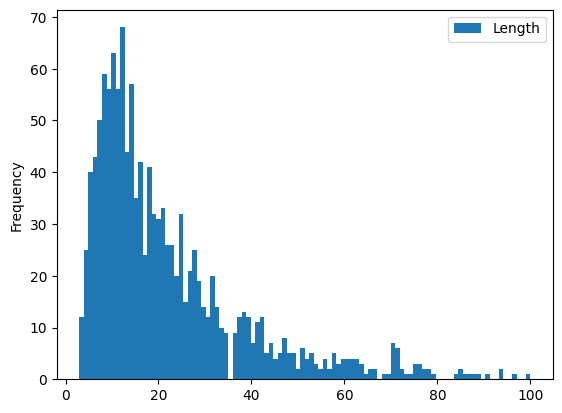

In [100]:
# distribution of lengths
lengths = [len(ts) for ts in tokenized_datasets['test']['input_ids']]
lengths = [l for l in lengths if l<= 100]

pd.DataFrame(lengths, columns = ['Length']).plot.hist(bins = 100) #.value_counts().plot(kind = 'barh', figsize = (8, 20))

## 2.2 ALBERT model for token Classification

[Table of content](#TOC)

In [101]:
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels = len(label_list),
    label2id = label2id,
    id2label = id2label,
)

Downloading: 100%|████████████████████████████████████████████████████████████████| 47.4M/47.4M [00:00<00:00, 49.9MB/s]
Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForTokenClassification: ['predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForTokenClassification were not initialized from the mo

In [102]:
model.num_parameters()

11112217

<a id="finetune"></a>

# 3. Finetuning

[Table of content](#TOC)

In [106]:
batch_size = 3

In [107]:
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels = len(label_list),
    label2id = label2id,
    id2label = id2label,
).to(device)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForTokenClassification: ['predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably

In [108]:
model = model.to(device)
model = model.train()

In [109]:
args = TrainingArguments(
    os.path.join(path_to_save, f"{dataset_name}-{model_name}-finetuned"),
    evaluation_strategy = "no",
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 5,
    weight_decay = 0.01,
    save_strategy = 'no',
)

In [111]:
metric = load_metric("seqeval")

In [112]:
trainer = Trainer(
    model,
    args,
    train_dataset = tokenized_datasets["all"],
    data_collator = data_collator,
    tokenizer = tokenizer,
    compute_metrics = lambda p: compute_metrics(p, metric, label_list),
)

In [113]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `AlbertForTokenClassification.forward` and have been ignored: ids, tokens, ner_tags. If ids, tokens, ner_tags are not expected by `AlbertForTokenClassification.forward`,  you can safely ignore this message.
C:\Users\jbaujogue\Anaconda3\envs\transformers_nlp\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12406
  Num Epochs = 5
  Instantaneous batch size per device = 3
  Total train batch size (w. parallel, distributed & accumulation) = 3
  Gradient Accumulation steps = 1
  Total optimization steps = 20680
You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster

Step,Training Loss
500,1.200300
1000,0.859800
1500,0.817400
2000,0.751200
2500,0.706400
3000,0.689700
3500,0.702300
4000,0.698600
4500,0.646900
5000,0.607700




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=20680, training_loss=0.4973431046742305, metrics={'train_runtime': 1545.9106, 'train_samples_per_second': 40.125, 'train_steps_per_second': 13.377, 'total_flos': 105772778561550.0, 'train_loss': 0.4973431046742305, 'epoch': 5.0})

In [114]:
model = model.to('cpu')

In [116]:
tokenizer.save_pretrained(os.path.join(path_to_save, f"{dataset_name}-{model_name}", 'tokenizer'))
model.save_pretrained(os.path.join(path_to_save, f"{dataset_name}-{model_name}", 'model'))

tokenizer config file saved in C:\Users\jbaujogue\Desktop\Tessella\Internal - Transformers for NLP\saves\NER\chia-albert-base-v2\tokenizer\tokenizer_config.json
Special tokens file saved in C:\Users\jbaujogue\Desktop\Tessella\Internal - Transformers for NLP\saves\NER\chia-albert-base-v2\tokenizer\special_tokens_map.json
Configuration saved in C:\Users\jbaujogue\Desktop\Tessella\Internal - Transformers for NLP\saves\NER\chia-albert-base-v2\model\config.json
Model weights saved in C:\Users\jbaujogue\Desktop\Tessella\Internal - Transformers for NLP\saves\NER\chia-albert-base-v2\model\pytorch_model.bin


<a id="inference"></a>

# 4. Inference

[Table of content](#TOC)

In [133]:
tokenizer = AutoTokenizer.from_pretrained(os.path.join(path_to_save, f"{dataset_name}-{model_name}", 'tokenizer'))
model = AutoModelForTokenClassification.from_pretrained(os.path.join(path_to_save, f"{dataset_name}-{model_name}", 'model'))

loading file spiece.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file C:\Users\jbaujogue\Desktop\Tessella\Internal - Transformers for NLP\saves\NER\chia-albert-base-v2\model\config.json
Model config AlbertConfig {
  "_name_or_path": "C:\\Users\\jbaujogue\\Desktop\\Tessella\\Internal - Transformers for NLP\\saves\\NER\\chia-albert-base-v2\\model",
  "architectures": [
    "AlbertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "B-Condition",
    "1": "B-Device",
    "2": "B-Drug",
    "3": "B-Measurement",
    "4": "B-Negation",
    "5": "B-Observation",
    "6": "B-Person",
    "7": "B-Procedure",
    "8": "B-Quali

In [134]:
ner = pipeline(
    task = 'ner', 
    model = model, 
    tokenizer = tokenizer,
    framework = 'pt',
    aggregation_strategy = 'simple',
)

In [161]:
sent = 'Polyneuropathy of other causes, including but not limited to hereditary demyelinating neuropathies, neuropathies secondary to infection or systemic disease, diabetic neuropathy, drug- or toxin-induced neuropathies, multifocal motor neuropathy, monoclonal gammopathy of uncertain significance, lumbosacral radiculoplexus neuropathy, pure sensory CIDP and acquired demyelinating symmetric (DADS) neuropathy (also known as distal CIDP).'

df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [160]:
sent = 'Adults and adolescent patients with a physician diagnosis of asthma ' +\
    'for ≥12 months, based on the Global Initiative for Asthma (GINA) 2014 Guidelines ' +\
    'and the followingcriteria: A) Existing treatment with medium to high dose ICS ' +\
    '(≥250 mcg of fluticasone propionate twice daily or equipotent ICS daily dosage ' +\
    'to a maximum of 2000 mcg/day of fluticasone propionate or equivalent) in combination ' +\
    'with a second controller (eg, LABA, LTRA) for at least 3 months with a stable dose ≥1 ' +\
    'month prior to Visit 1.'

df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [151]:
sent = 'Biologics treatment: Cell-depleting agents, eg. Rituximab Drug within 6 months before baseline or until lymphocyte count returns to normal, Other biologics: within 5 half-lives or 16 weeks prior baseline.'

df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [148]:
sents = '''Active hepatitis or patients with positive HBsAg, or patients with positive HBcAb plus positive HBV DNA, or positive HCV antibody (confirmed with presence of HCV RNA if needed) at screening.

History of alcohol or drug abuse within 2 years of the screening visit.

History of HIV infection or positive HIV serology at screening.

History of malignancy within 5 years before screening, except completely treated cervix carcinoma, completely treated and resolved non-metastatic squamous or basal cell carcinoma of the skin.

Infection requires systemic antibiotics, antivirals, antiparasitics, antiprotozoals, antifungals treatment within 2 weeks before baseline, superficial skin infections within 1 week before baseline visit.

Initiation AD treatment with prescription moisturizers or moisturizers containing  additives such as ceramide, hyaluronic acid, urea, or filaggrin degradation products during the screening period.

Known or suspected history of immunosuppression, including history of invasive opportunistic infections, despite infection resolution, or unusually frequent, recurrent, or prolonged infections.
'''
df_list = []
html = ''
for sent in sents.split('\n'):
    if sent.strip():
        ents = parse_trf_ner_output(ner(sent))
        ents = correct_entity_boundaries(sent, ents)
        ents = remove_entity_overlaps(ents)
        df_list.append(ents)
        html += render_ner_as_html(sent, ents)

df_ents = pd.concat(df_list, ignore_index = True)
HTML(html)

[Table of content](#TOC)